In [1]:
import fastbook

fastbook.setup_book()

## Gather MNIST data

### Download dataset

In [2]:
from pathlib import Path

from fastai.data.external import URLs, untar_data

path = untar_data(URLs.MNIST)
print(f"MNIST data downloaded to {path}")
# Path.BASE_PATH = path

MNIST data downloaded to /Users/david/.fastai/data/mnist_png


### Define how to access images from training and testing datasets

In [3]:
from enum import Enum
from functools import cache
from typing import List, Literal

from fastai.torch_core import tensor
from PIL import Image

Digit = Literal[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


class DataSet(Enum):
    TRAINING = "training"
    TESTING = "testing"


def get_digit_file_paths(digit: Digit, dataset: DataSet) -> List[Path]:
    return list((path / dataset.value / str(digit)).ls().sorted())


@cache
def get_digit_tensors(digit: Digit, dataset: DataSet) -> List[tensor]:
    """Gets all tensor images for the given digit in the specified DataSet."""
    return [tensor(Image.open(path)) for path in get_digit_file_paths(digit, dataset)]


#### Peek into the images

In [4]:
im4 = Image.open(get_digit_file_paths(4, DataSet.TRAINING)[0])
print(f"Image shape is {im4.shape}")
im4

Image shape is (28, 28)


#### Images as tensors:

<Axes: >

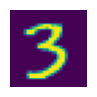

In [5]:
from fastai.torch_core import show_image

show_image(get_digit_tensors(3, DataSet.TRAINING)[1])

## Some utilities

In [6]:
from typing import Final, Tuple

import torch
from torch import Tensor

IMAGE_SHAPE: Final[Tuple[int, int]] = (28, 28)


class EmptyInputError(Exception):
    pass


class TensorShapeError(Exception):
    def __init__(self, message: str, offending_tensor: Tensor):
        self.offending_tensor = offending_tensor
        super().__init__(message)


def ensure_shape(tensor: Tensor, expected: Tuple[int, ...]) -> tensor:
    """Validates tensor shape matches expected dimensions. Use -1 for 'any'."""
    if len(tensor.shape) != len(expected):
        raise TensorShapeError(
            "Tensor shape and expected shape must have the "
            "same number of dimensions. "
            f"Got {len(tensor.shape)} and {len(expected)}.",
            tensor,
        )
    for actual, expected in zip(tensor.shape, expected):
        if expected == -1:
            continue
        if actual != expected:
            raise TensorShapeError(
                f"Expected shape {expected}, got {tensor.shape}", tensor
            )
    return tensor


In [7]:
from typing import Sequence


def stack_image_tensors(image_tensors: Sequence[tensor]) -> Tensor:
    """Takes a sequence of MNIST digit image tensors and returns a single tensor
    whose first dimension refers to each of the images."""

    if len(image_tensors) == 0:
        raise EmptyInputError(
            "The input sequence of tensors must have at least one element."
        )

    for t in image_tensors:
        ensure_shape(t, IMAGE_SHAPE)

    # It may be silly to wrap this in a function, but doing so adds some semantics
    # and checks that the input has the expected shape.
    stacked = torch.stack(image_tensors)

    # This should never raise, so it just documents what I'm expecting.
    ensure_shape(stacked, (-1,) + IMAGE_SHAPE)
    return stacked


def normalize(input: Tensor) -> Tensor:
    """Probably not a good name. Takes a tensor of image data with pixel values
    between 0 and 255 and returns a tensor with float values between 0 and 1"""
    return input.float() / 255

@cache
def get_stacked_preprocessed_digits(digit: Digit, dataset: DataSet) -> Tensor:
    """Gets all images for a given digit in the specified dataset, stacked in a
    single tensor and normalized."""
    return normalize(stack_image_tensors(get_digit_tensors(digit, dataset)))

In [8]:
#| test
def test_stacked_threes():
    stacked_training_threes = stack_image_tensors(get_digit_tensors(3, DataSet.TRAINING))
    # A stacked tensor of threes is rank-3 with ~6k images, each of which is 28 x 28 pixels.
    assert(stacked_training_threes.shape == (6131,) + IMAGE_SHAPE)

<Axes: >

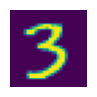

In [9]:
test_stacked_threes()
show_image(stack_image_tensors(get_digit_tensors(3, DataSet.TRAINING))[1])

## Baseline: Pixel Similarity

### Calculating the mean digit images

In [10]:
def mean_image(stacked_images: Tensor) -> Tensor:
    """Calculates the "ideal" digit image, composed of the mean pixel values from
    each of the images in the first (0) dimension in the `stacked_images` argument."""
    ensure_shape(stacked_images, (-1,) + IMAGE_SHAPE)
    mean = torch.mean(
        stacked_images, 0, dtype=float
    )  # why can't pytorch infer the dtype?
    ensure_shape(mean, IMAGE_SHAPE)
    return mean


@cache
def mean_digit_image(digit: Digit, dataset: DataSet) -> Tensor:
    """Gets an averaged image for a given digit in a specified DataSet."""
    return mean_image(get_stacked_preprocessed_digits(digit, dataset))


def mean_digit_images(dataset: DataSet) -> Tensor:
    """Returns the averaged image for each digit for the specified DataSet."""
    return torch.stack([mean_digit_image(digit, dataset) for digit in range(0, 10)])


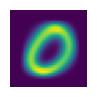

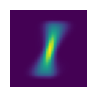

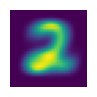

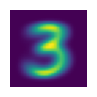

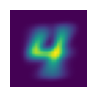

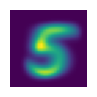

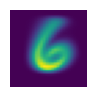

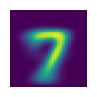

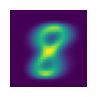

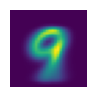

In [11]:
for digit in range(0, 10):
    show_image(mean_digit_images(DataSet.TRAINING)[digit])


### Calculating how close a given digit image is from the "ideal", or mean image for that digit

* Mean absolute difference, or L1 norm, is the mean of the absolute value of the differences between pixels.
* Root mean square error, RMSE, or L2 norm, takes the mean of the squares of the differences and then the square root of that mean.
  * this one penalizes larger mistakes more and smaller mistakes less

In [12]:
def l1_norm(candidate: Tensor, ideal: Tensor) -> Tensor:
    """Calculates the mean of the absolute value of the differences between
    pixels of the candidate and the "ideal" image tensors.
    Returns a scalar wrapped in a rank-0 tensor."""
    ensure_shape(candidate, IMAGE_SHAPE)
    ensure_shape(ideal, IMAGE_SHAPE)
    result = (candidate - ideal).abs().mean()
    ensure_shape(result, ())
    return result


def l2_norm(candidate: Tensor, ideal: Tensor) -> Tensor:
    """Calculates the root of the mean of the squares of the differences
    (that is diff_tensor -> square -> mean_scalar -> sqrt)
    between pixels of the candidate and the "ideal" image tensors.
    Returns a scalar wrapped in a rank-0 tensor."""
    ensure_shape(candidate, IMAGE_SHAPE)
    ensure_shape(ideal, IMAGE_SHAPE)
    result = ((candidate - ideal) ** 2).mean().sqrt()
    ensure_shape(result, ())
    return result

In [13]:
[
    norm_function(
        get_stacked_preprocessed_digits(3, DataSet.TRAINING)[0],
        mean_digit_image(3, DataSet.TRAINING),
    )
    for norm_function in [l1_norm, l2_norm]
]

[tensor(0.1074, dtype=torch.float64), tensor(0.1912, dtype=torch.float64)]

In [14]:
# TODO: Consider removing check_shape
def mnist_distance(
    candidate_s: Tensor, ideal: Tensor, check_shape: bool = True
) -> Tensor:
    """Calculates the "distance(s)" between a candidate image tensor OR a tensor of
    candidate image tensors and an "ideal" image tensor.
    If passed a single candidate it will return a scalar wrapped in a rank-0 tensor,
    and if passed a tensor of candidates it will return a rank-1 tensor with the
    corresponding distances (by broadcasting the "ideal" tensor.)
    The "distance(s)" is/are calculated by taking the absolute difference of the pixel
    values of candidate-ideal image pairs and calculating the mean of those pixel
    differences, resulting in a scalar for each of the candidates."""
    if check_shape:
        if candidate_s.ndim == 2:  # single image
            ensure_shape(candidate_s, IMAGE_SHAPE)
        else:  # many images
            ensure_shape(candidate_s, (-1,) + IMAGE_SHAPE)

    distance_s = (candidate_s - ideal).abs().mean((-1, -2))
    # "The tuple (-1,-2) represents a range of axes. In Python, -1 refers to the
    # last element, and -2 refers to the second-to-last. So in this case, this
    # tells PyTorch that we want to take the mean ranging over the values indexed
    # by the last two axes of the tensor. The last two axes are the horizontal
    # and vertical dimensions of an image."

    if check_shape:
        if candidate_s.ndim == 2:
            # The output is a rank-0 tensor wrapping a single distance value for
            # one image.
            ensure_shape(distance_s, ())
        else:
            # The output vector has as many distance values as there are images in
            # the input tensor.
            ensure_shape(distance_s, (candidate_s.shape[0],))
    return distance_s


#### Distance between a three and the ideal three

In [15]:
_distance = mnist_distance(
    get_stacked_preprocessed_digits(3, DataSet.TRAINING)[0],
    mean_digit_image(3, DataSet.TRAINING),
)
print(f"shape: {_distance.shape}")
_distance

shape: torch.Size([])


tensor(0.1074, dtype=torch.float64)

#### Distances between each of the threes and the ideal three

In [16]:
_distances = mnist_distance(
    get_stacked_preprocessed_digits(3, DataSet.TRAINING),
    mean_digit_image(3, DataSet.TRAINING),
)
print(f"shape: {_distances.shape}")
_distances

shape: torch.Size([6131])


tensor([0.1074, 0.1114, 0.1100,  ..., 0.1316, 0.1220, 0.1267], dtype=torch.float64)

#### Distance between a concrete three and each of the ideal digits

In [17]:
_distances = mnist_distance(
    get_stacked_preprocessed_digits(3, DataSet.TRAINING)[0],
    mean_digit_images(DataSet.TRAINING),
    check_shape=False
)
print(f"shape: {_distances.shape}")
_distances

shape: torch.Size([10])


tensor([0.1750, 0.1153, 0.1501, 0.1074, 0.1635, 0.1326, 0.1579, 0.1441, 0.1345, 0.1402], dtype=torch.float64)

#### Distance between each of the threes and each of the ideal digits

In [18]:
# I'm going to use this later so I'll wrap it in a function
def calculate_distances(
    digit: Digit, from_dataset: DataSet, to_ideal_digits_dataset: DataSet
) -> Tensor:
    expected_digit_count = len(get_digit_file_paths(digit, from_dataset))
    shaped_concrete_digits = get_stacked_preprocessed_digits(
        digit, from_dataset
    ).unsqueeze(1)
    ensure_shape(
        shaped_concrete_digits, (expected_digit_count, 1) + IMAGE_SHAPE
    )  # [~6K, 1, 28, 28]
    shaped_means = mean_digit_images(DataSet.TRAINING).unsqueeze(0)
    ensure_shape(shaped_means, (1, 10, 28, 28))
    distances = mnist_distance(shaped_concrete_digits, shaped_means, check_shape=False)
    ensure_shape(distances, (expected_digit_count, 10))  # [~6K, 10]
    return distances

In [19]:
_distances = calculate_distances(
    digit=3,
    from_dataset=DataSet.TRAINING,
    to_ideal_digits_dataset=DataSet.TRAINING,
)
print(f"shape: {_distances.shape}")
_distances

shape: torch.Size([6131, 10])


tensor([[0.1750, 0.1153, 0.1501,  ..., 0.1441, 0.1345, 0.1402],
        [0.1879, 0.1353, 0.1734,  ..., 0.1586, 0.1550, 0.1601],
        [0.1644, 0.1433, 0.1583,  ..., 0.1541, 0.1343, 0.1580],
        ...,
        [0.1793, 0.1582, 0.1610,  ..., 0.1792, 0.1474, 0.1682],
        [0.1531, 0.1253, 0.1451,  ..., 0.1548, 0.1519, 0.1636],
        [0.1655, 0.1257, 0.1459,  ..., 0.1509, 0.1496, 0.1622]], dtype=torch.float64)

#### Distance between each concrete digit and each of the ideal digits

In [20]:
# Will use a loop instead of broadcasting because the training sets of different
# digits have different lengths. Alternatively I could cap all of them to the
# same length.
[
    calculate_distances(
        digit,
        from_dataset=DataSet.TRAINING,
        to_ideal_digits_dataset=DataSet.TRAINING
    )
    for digit in range(0, 10)
]

[tensor([[0.1108, 0.1643, 0.1788,  ..., 0.1690, 0.1708, 0.1694],
         [0.1388, 0.1526, 0.1672,  ..., 0.1497, 0.1403, 0.1419],
         [0.1648, 0.2191, 0.2223,  ..., 0.2229, 0.1988, 0.2094],
         ...,
         [0.1840, 0.2321, 0.2240,  ..., 0.1964, 0.2131, 0.1986],
         [0.1632, 0.1615, 0.1785,  ..., 0.1630, 0.1811, 0.1789],
         [0.1759, 0.1757, 0.1972,  ..., 0.1652, 0.1886, 0.1731]], dtype=torch.float64),
 tensor([[0.1806, 0.0530, 0.1449,  ..., 0.1242, 0.1341, 0.1291],
         [0.1887, 0.0601, 0.1335,  ..., 0.1253, 0.1335, 0.1288],
         [0.1778, 0.0636, 0.1443,  ..., 0.1152, 0.1388, 0.1200],
         ...,
         [0.1927, 0.0658, 0.1367,  ..., 0.1443, 0.1331, 0.1428],
         [0.1961, 0.0737, 0.1385,  ..., 0.1479, 0.1319, 0.1455],
         [0.1890, 0.0519, 0.1433,  ..., 0.1300, 0.1319, 0.1326]], dtype=torch.float64),
 tensor([[0.1959, 0.1587, 0.1350,  ..., 0.1854, 0.1608, 0.1797],
         [0.1822, 0.1275, 0.1243,  ..., 0.1417, 0.1509, 0.1457],
         [0.1836

In [21]:
# given a concrete digit, which ideal digit is it closer to?
def match(image: Tensor, ideals: Tensor) -> Digit:
    ensure_shape(image, IMAGE_SHAPE)
    ensure_shape(ideals, (10,) + IMAGE_SHAPE)
    distances = mnist_distance(image, ideals, check_shape=False)
    ensure_shape(distances, (10,))
    # if there's more than one min this will produce the index of the first one
    min_indexes = torch.argmin(distances)
    min_index = min_indexes.item()
    assert min_index in range(0, 10)
    return min_index


In [22]:
match(
    image=get_stacked_preprocessed_digits(8, DataSet.TRAINING)[3],
    ideals=mean_digit_images(DataSet.TRAINING),
)

1

In [23]:
# given a tensor of stacked digit images, which ideal digit is each closer to?
def matches_for_images(images, ideals: Tensor) -> Tensor:
    ensure_shape(images, (-1,) + IMAGE_SHAPE)
    image_count = images.shape[0]
    shaped_images = images.unsqueeze(1)
    ensure_shape(shaped_images, (image_count, 1) + IMAGE_SHAPE)
    ensure_shape(ideals, (10,) + IMAGE_SHAPE)
    shaped_ideals = ideals.unsqueeze(0)
    ensure_shape(shaped_ideals, (1, 10) + IMAGE_SHAPE)
    distances = mnist_distance(shaped_images, shaped_ideals, check_shape=False)
    ensure_shape(distances, (image_count, 10))
    digits = torch.argmin(distances, dim=1)
    ensure_shape(digits, (image_count,))
    return digits


def matches_for_digit(
    digit: Digit,
    from_dataset: DataSet,
    ideals_dataset: DataSet,
) -> Tensor:
    return matches_for_images(
        images=get_stacked_preprocessed_digits(digit, from_dataset),
        ideals=mean_digit_images(ideals_dataset),
    )

matches_for_digit(
    3,
    from_dataset=DataSet.TRAINING,
    ideals_dataset=DataSet.TRAINING,
)

In [24]:
_matches_3s = matches_for_images(
    images=get_stacked_preprocessed_digits(3, DataSet.TRAINING),
    ideals=mean_digit_images(DataSet.TRAINING),
)
_correct_3s = _matches_3s == 3
_correct_3s

tensor([ True,  True,  True,  ...,  True,  True, False])

In [25]:
_correct_3s.float().mean()

tensor(0.5836)

In [26]:
[matches_for_digit(digit, DataSet.TRAINING, DataSet.TRAINING) for digit in range(0, 10)]

[tensor([0, 5, 0,  ..., 0, 1, 7]),
 tensor([1, 1, 1,  ..., 1, 1, 1]),
 tensor([2, 2, 1,  ..., 1, 9, 2]),
 tensor([3, 3, 3,  ..., 3, 3, 1]),
 tensor([4, 9, 4,  ..., 4, 4, 4]),
 tensor([5, 1, 5,  ..., 1, 5, 1]),
 tensor([6, 1, 1,  ..., 6, 1, 1]),
 tensor([7, 7, 7,  ..., 7, 7, 7]),
 tensor([1, 3, 1,  ..., 1, 1, 1]),
 tensor([9, 9, 9,  ..., 9, 7, 9])]

In [27]:
def baseline_accuracy(
    digit: Digit,
    from_dataset: DataSet,
    ideals_dataset: DataSet,
) -> Tensor:
    matches = matches_for_digit(digit, from_dataset, ideals_dataset)
    corrects = matches == digit
    accuracy = corrects.float().mean()
    ensure_shape(accuracy, ())  # returns a rank-0 tensor
    return accuracy


def baseline_accuracies(
    from_dataset: DataSet,
    ideals_dataset: DataSet,
) -> List[float]:
    # digits have different counts of samples
    # so this is iterated instead of broadcasted
    return [
        baseline_accuracy(digit, from_dataset, ideals_dataset).item()
        for digit in range(0, 10)
    ]

In [28]:
for (i, calculate_accuracy) in enumerate(baseline_accuracies(DataSet.TRAINING, DataSet.TRAINING)):
    print(f"{i}: {calculate_accuracy:.3f}")

0: 0.814
1: 0.998
2: 0.433
3: 0.584
4: 0.665
5: 0.300
6: 0.745
7: 0.778
8: 0.396
9: 0.716


## Now as a model

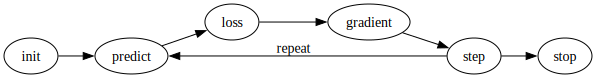

In [29]:
from fastbook import gv

gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [30]:
from functools import reduce


def labeled_data(dataset: DataSet) -> Tuple[Tensor, Tensor]:
    _all_digits = range(0, 10)
    _stacked_digits = [
        get_stacked_preprocessed_digits(digit, dataset) for digit in _all_digits
    ]
    _lengths = [len(get_digit_file_paths(digit, dataset)) for digit in _all_digits]

    train_x = torch.cat(_stacked_digits).view(-1, IMAGE_SHAPE[0] * IMAGE_SHAPE[1])
    train_y = tensor(
        reduce(lambda a, b: a + b, [[digit] * _lengths[digit] for digit in _all_digits]),
        dtype=torch.int64,
    ).unsqueeze(1)  # TODO: why unsqueeze?
    return (train_x, train_y)

train_x, train_y = labeled_data(DataSet.TRAINING)
valid_x, valid_y = labeled_data(DataSet.TESTING)
print(f"Training: {train_x.shape, train_y.shape}")
print(f"Validation - testing: {valid_x.shape, valid_y.shape}")

Training: (torch.Size([60000, 784]), torch.Size([60000, 1]))
Validation - testing: (torch.Size([10000, 784]), torch.Size([10000, 1]))


A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. 
It looks like this: $[(x_1,y_1), (x_2,y_2), ... (x_n,y_n)]$

In [31]:
training_dset = list(zip(train_x, train_y))

In [32]:
x,y = training_dset[0]
x.shape, y  # TODO: is this why unsqueeze above?

(torch.Size([784]), tensor([0]))

### Initialize parameters

In [33]:
from typing import Union

from torch import SymInt


def init_params(shape: Union[int, SymInt], std: float = 1.0) -> Tensor:
    return (torch.randn(shape) * std).requires_grad_()

In the book the model has to differentiate between 2 digits, so the model has a single output. 0.0 is used as some kind of threshold: any values greater than 0 represent a prediction for one digit, the others represent the other digit. For this 2-digit model, `train_y` is a vector of 1s for one digit and 0s for the other digit. (And then unsqueezed to a second dimension of size 1).

0 is at the center of the model outputs distribution, then they switch it to 0.5 (that is, all values between 0 and 1) using **sigmoid**.

I want to switch the model from having one input $y_1$ (probability of input being digit a, and $y_2=1-y_1$) to 10 outputs (originally I was thinking 9 so I would calculate the 10th as $1-p(others)$, but it makes more sense to use Softmax for 10 outputs, as the probs of the 10 should add to 1).

In [34]:
count_outputs = 10

In [35]:
weights = init_params((IMAGE_SHAPE[0] * IMAGE_SHAPE[1], count_outputs))
biases = init_params(count_outputs)

In [36]:
print(f"Shape of the full training data: {train_x.shape}")
print(f"Shape of the weights: {weights.shape}")

Shape of the full training data: torch.Size([60000, 784])
Shape of the weights: torch.Size([784, 10])


### Run the model once for a single image

In [37]:
first_image = train_x[0]
print(f"Shape of the first image: {first_image.shape}")

# the T is transpose, flipping weights from [784, count_outputs] to [count_outputs, 784]
transposed_weights = weights.T
print(f"Shape of transposed weights: {transposed_weights.shape}")

element_wise_product = first_image * transposed_weights
print(f"Shape of element-wise multiplication: {element_wise_product.shape}")

model_result = element_wise_product.sum() + biases
print(f"Shape of model result: {model_result.shape}")
print(f"Model result: {model_result}")

Shape of the first image: torch.Size([784])
Shape of transposed weights: torch.Size([10, 784])
Shape of element-wise multiplication: torch.Size([10, 784])
Shape of model result: torch.Size([10])
Model result: tensor([7.6105, 5.8626, 6.7214, 7.5525, 6.7721, 7.8905, 7.7074, 6.4941, 7.1839, 7.0970], grad_fn=<AddBackward0>)


### Run the model once for all training data using broadcasting (no loops!)

How I think the `batch @ weights + bias`, equation operates in a linear model with several outputs: it has 9 sets of parameters and 9 biases. So I'm imagining it's just that equation once per output probability, with the same input data, independently and in parallel.

In [38]:
batch = train_x

print(f"Shape of batch: {batch.shape}")
print(f"Shape of weights: {weights.shape}")
print(f"Shape of bias: {biases.shape}")


# Here is one of the two magic equations (the other one is the activation
# function), equivalent to doing the run above but for each image in the batch
# (in this case the full training set).
model_result = batch @ weights + biases

print(f"Shape of results: {model_result.shape}")

Shape of batch: torch.Size([60000, 784])
Shape of weights: torch.Size([784, 10])
Shape of bias: torch.Size([10])
Shape of results: torch.Size([60000, 10])


In [39]:
# Wrapped in a class, together with its weights and biases, like models
# in the pytorch nn package:

from abc import ABC, abstractmethod


class Model(ABC):
    @abstractmethod
    def run(self, batch: Tensor) -> Tensor:
        pass

    @abstractmethod
    def reset_params(self) -> None:
        pass


class LinearModel(Model):
    def __init__(self, in_features: int, out_features: int):
        self.in_features = in_features
        self.out_features = out_features
        self.reset_params()

    def reset_params(self):
        self.weights = init_params((self.in_features, self.out_features))
        self.biases = init_params(self.out_features)

    def run(self, batch: Tensor) -> Tensor:
        # Apply linear transformation: batch @ weights + biases
        linear = batch @ self.weights + self.biases
        return linear  # return unnormalized logits


linear_model = LinearModel(
    in_features=IMAGE_SHAPE[0] * IMAGE_SHAPE[1], out_features=count_outputs
)

### Function to calculate the accuracy

In [40]:
def calculate_accuracy(preds: Tensor, labels: Tensor) -> float:
    ensure_shape(labels, (preds.shape[0], 1))
    preds_as_digits = preds.argmax(dim=1)
    correct = preds_as_digits == labels
    return correct.float().mean().item()


In [41]:
calculate_accuracy(linear_model.run(valid_x), valid_y)

0.09389954060316086

### Function to calculate the loss

Even though the normalization step (such as Softmax) seems to conceptually fit better with the model, I see it being used in the loss function.

In [42]:
def calculate_loss(logits: Tensor, targets: Tensor) -> Tensor:
    predictions = torch.log_softmax(logits, dim=1)
    ensure_shape(targets, (predictions.shape[0], 1))
    probs_right_guesses = torch.gather(predictions, dim=1, index=targets)
    losses = 1 - probs_right_guesses
    return ensure_shape(losses.sum(), ())

In [43]:
calculate_loss(linear_model.run(train_x), train_y)

tensor(954260.2500, grad_fn=<SumBackward0>)

### Infrastructure to iterate over batches

A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`

tensor([6])

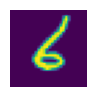

In [44]:
train_dataset = list(zip(train_x, train_y))
valid_dataset = list(zip(valid_x, valid_y))

_index = 40000
show_image(train_dataset[_index][0].view((IMAGE_SHAPE)))
train_dataset[_index][1]

When we pass a Dataset to a DataLoader we will get back many batches that are themselves tuples of tensors representing batches of independent and dependent variables

In [45]:
from fastai.data.load import DataLoader

train_dl = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=256)

digit=2
digit=9


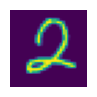

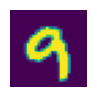

In [46]:
_first_batch = list(train_dl)[0]

_images, _digits = _first_batch  # TODO: grok why this is not the opposite of zip
for image, digit in list(zip(_images, _digits))[0:2]:
    show_image(image.view(IMAGE_SHAPE))
    print(f"digit={digit.item()}")

### Cycle of training

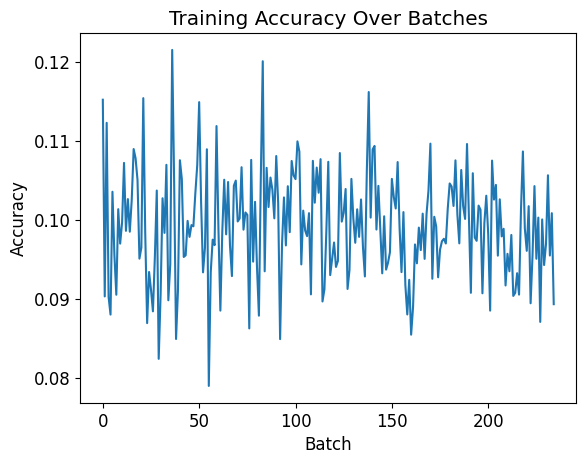

In [47]:
import matplotlib.pyplot as plt

linear_model.reset_params()

lr = 1e-5

accuracies = []
for x, y in train_dl:
    preds = linear_model.run(x)
    acc = calculate_accuracy(preds, y)
    # print(f"Accuracy: {acc}")
    accuracies.append(acc)

    loss = calculate_loss(preds, y)
    loss.backward()
    linear_model.weights.data -= linear_model.weights.grad.data * lr
    linear_model.biases.data -= linear_model.biases.grad.data * lr
    linear_model.weights.grad.zero_()
    linear_model.biases.grad.zero_()

plt.plot(accuracies)
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Batches')
plt.show()


That didn't work. Try with off-the-shelf components and code copied from the book but with 10 outputs. With 1 or 2 layers with a non linearity in between.

In [70]:
from fastai.optimizer import SGD
from torch import nn
import torch.nn.functional as F

nn_model = nn.Linear(IMAGE_SHAPE[0] * IMAGE_SHAPE[1], count_outputs)
# nn_model = nn.Sequential(
#     nn.Linear(IMAGE_SHAPE[0] * IMAGE_SHAPE[1], 30),
#     nn.modules.activation.ReLU(),
#     nn.Linear(30, count_outputs)
# )
opt = SGD(nn_model.parameters(), lr)

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = F.cross_entropy(preds, F.one_hot(torch.squeeze(yb)).float())

    loss.backward()

def train_epoch(model):
    for xb,yb in train_dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

train_model(nn_model, 200)


0.0885 0.0886 0.0885 0.0885 0.0886 0.0886 0.0886 0.0886 0.0887 0.0887 0.0888 0.0887 0.0887 0.0888 0.0889 0.089 0.0891 0.0892 0.0893 0.0894 0.0895 0.0898 0.0899 0.0899 0.0901 0.0901 0.0901 0.0904 0.0907 0.0907 0.091 0.0912 0.0913 0.0913 0.0916 0.0915 0.0917 0.0918 0.0919 0.092 0.0921 0.0922 0.0922 0.0924 0.0925 0.0924 0.0925 0.0926 0.0926 0.0927 0.0927 0.0927 0.0929 0.0928 0.0929 0.093 0.0929 0.093 0.093 0.0929 0.0929 0.0928 0.0929 0.0929 0.0926 0.0926 0.0926 0.0924 0.0925 0.0925 0.0924 0.0923 0.0921 0.0919 0.0918 0.0919 0.092 0.092 0.0921 0.0921 0.092 0.0919 0.0918 0.0918 0.0919 0.0917 0.0917 0.0917 0.0917 0.0916 0.0916 0.0916 0.0915 0.0915 0.0915 0.0914 0.0914 0.0912 0.0911 0.0911 0.091 0.0908 0.0907 0.0906 0.0906 0.0905 0.0905 0.0906 0.0906 0.0906 0.0905 0.0904 0.0903 0.0903 0.0903 0.0903 0.0902 0.0902 0.0902 0.0902 0.0902 0.0902 0.0901 0.09 0.09 0.0899 0.0898 0.0897 0.0896 0.0895 0.0895 0.0894 0.0894 0.0893 0.0893 0.0892 0.0892 0.0892 0.0892 0.0892 0.0891 0.0892 0.0892 0.0892 0.0891

KeyboardInterrupt: 

In [68]:
# Like above but step by step

from fastcore.basics import first

nn_model = nn.Linear(IMAGE_SHAPE[0] * IMAGE_SHAPE[1], count_outputs)
opt = SGD(nn_model.parameters(), lr)
xb, yb = first(train_dl)
yb = torch.squeeze(yb)
print(f"xb, yb shapes: {xb.shape, yb.shape}")

preds = nn_model(xb)
targets = F.one_hot(yb).float()
print(f"predictions, targets shapes: {preds.shape, targets.shape}")
loss = F.cross_entropy(preds, targets)


xb, yb shapes: (torch.Size([256, 784]), torch.Size([256]))
predictions, targets shapes: (torch.Size([256, 10]), torch.Size([256, 10]))


In [64]:
train_y.shape

torch.Size([60000, 1])

In [62]:
F.one_hot(yb[0], count_outputs)

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [54]:
help(F.one_hot)

Help on built-in function one_hot in module torch._C._nn:

one_hot(...)
    one_hot(tensor, num_classes=-1) -> LongTensor
    
    Takes LongTensor with index values of shape ``(*)`` and returns a tensor
    of shape ``(*, num_classes)`` that have zeros everywhere except where the
    index of last dimension matches the corresponding value of the input tensor,
    in which case it will be 1.
    
    See also `One-hot on Wikipedia`_ .
    
    .. _One-hot on Wikipedia:
        https://en.wikipedia.org/wiki/One-hot
    
    Arguments:
        tensor (LongTensor): class values of any shape.
        num_classes (int):  Total number of classes. If set to -1, the number
            of classes will be inferred as one greater than the largest class
            value in the input tensor.
    
    Returns:
        LongTensor that has one more dimension with 1 values at the
        index of last dimension indicated by the input, and 0 everywhere
        else.
    
    Examples:
        >>> F.one

Nope. Not working.

* Is the problem in my loss function?
* Try log_softmax, etc https://forums.fast.ai/t/fastbook-chapter-4-questionnaire-solutions-wiki/67253/24 